<a href="https://colab.research.google.com/github/samuelmcilrath/forest-fires/blob/main/forestfires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forest Fire Regression - Sam McIlrath and Olivia Creighton

## Data
Forest fires are highly detrimental to various communities and ecosystems. Their spread is determined by a variety of factors, including weather, topography, and ground cover. We wanted to determine if meteorological data and data on the ground cover could predict the spread of a forest fire. 

Features include:

**X, Y**: Spatial coordinates within a Monteshino Park map

**Month, day**: "jan" to "dec" and "mon" to "sun"

**FFMC**: Fine Fuel Moisture Code; the amount of moisture in the litter/fuel on the ground; relative measure of ease of ignition and flammability

**DMC**: Duff Moisture Code; the amount of moisture in the top layer of soil

**DC**: Drought Code; the amount of moisture of deeper soil

**ISI**: Initial Spread Index; expected rate of fire spread, based on windspeed and FFMC

**Temp**: Temperature in Celsius degrees

**RH**: Relative humidity in %

**Wind**: Wind speed in km/h

**Rain**: Outside rain in mm/m2

**Area**: Burned area in hectares

FFMC, DMC, and DC according to the FWI (https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi)

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR, SVC, LinearSVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures


import matplotlib.pyplot as plt
%matplotlib inline

# Set the path to the file you'd like to load
file_path = "C:\MAIN\School\ML\Sem Proj\forest-fires\forestfires.ipynb"

# Load the latest version
forest_fires = pd.read_csv("forestfires_dataset.csv")

print("First 5 records: \n", forest_fires.head())

First 5 records: 
    X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0


This is what the dataset looks like!

For funsies, though the  X and Y data is vague, it shows a bit of what the park looks like.

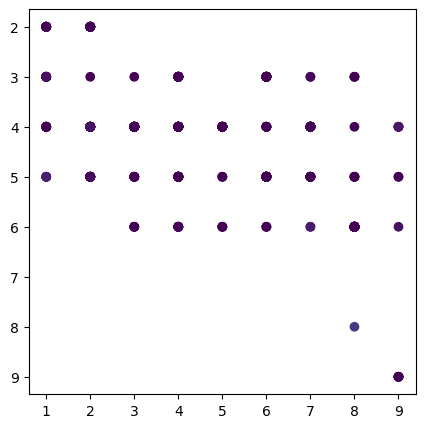

In [153]:
plt.figure(figsize=(5,5))
plt.scatter(forest_fires.loc[:,'X'], forest_fires.loc[:,'Y'], c=forest_fires.loc[:,'area'])
plt.gca().invert_yaxis() 

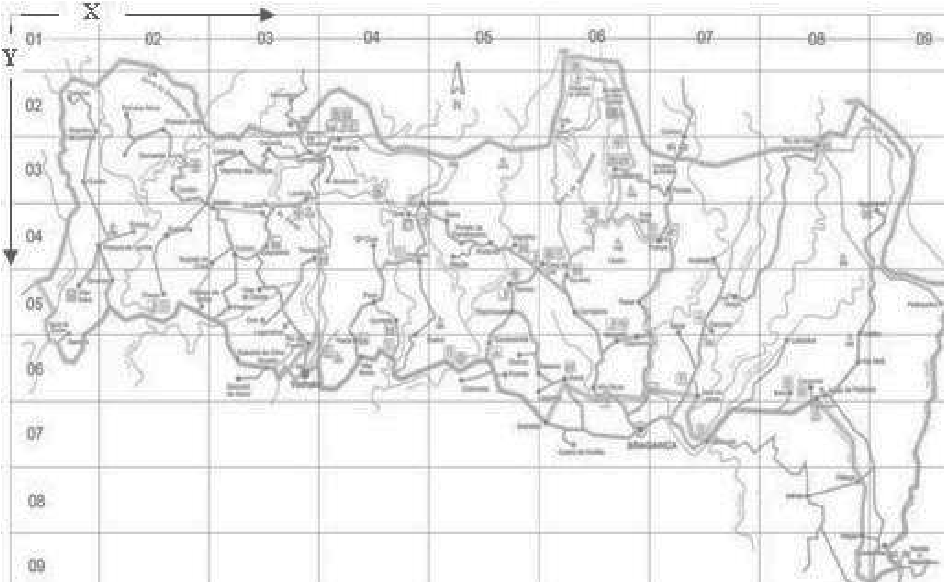

### Data Transformation

First, we transformed our data to standardize its mean to 0, because it had such high variability

In [154]:
###Transform Data - get splits
#forest_fires = forest_fires.drop(columns=['month', 'day']) #drop month and day columns

X = forest_fires.drop(columns=['month','day','area', 'X', 'Y'])
Y = forest_fires[['area']]

Y_log = np.log1p(Y) #skewed to 0, apply log 

# Standardize numerical features - this standardizes mean to 0
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Transformed records: \n", X_scaled[0])

# Split into training and test sets
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_scaled, Y_log, test_size=0.2, random_state=42
)

# Split into training and test sets
X_train_base, X_test_base, y_train, y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42
)
##note 
#if going with classifier, try to make amounts of nonburn to burn 

Transformed records: 
 [-0.80595947 -1.32332557 -1.83047676 -0.86094557 -1.84264015  0.41172435
  1.49861442 -0.07326831]


In [155]:
### Data Transformation
count = 0
for i in forest_fires['area']:
    if i == 0:
        count += 1
print(count)    

# Count zeros in the area column
zero_count = (forest_fires['area'] == 0).sum()
print(f"Number of zeros in area column: {zero_count}")

# Let's also see the total number of rows for comparison
total_rows = len(forest_fires)
print(f"Total number of rows: {total_rows}")


247
Number of zeros in area column: 247
Total number of rows: 517


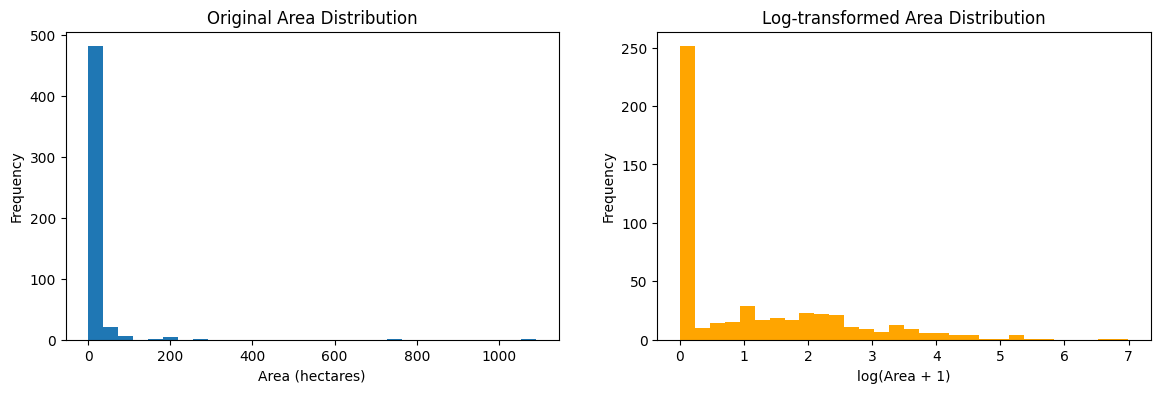

In [156]:
# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Original distribution
ax1.hist(forest_fires['area'], bins=30)
ax1.set_title('Original Area Distribution')
ax1.set_xlabel('Area (hectares)')
ax1.set_ylabel('Frequency')

# Log-transformed distribution
ax2.hist(np.log1p(forest_fires['area']), bins=30, color='orange')
ax2.set_title('Log-transformed Area Distribution')
ax2.set_xlabel('log(Area + 1)')
ax2.set_ylabel('Frequency')

plt.show()

## Regression Models

In [157]:
# A helper function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test, is_log_transformed=True):
    # Get predictions
    y_pred = model.predict(X_test)
    
    if is_log_transformed:
        # For log-transformed data, convert back to original scale
        y_pred = np.expm1(y_pred)
        y_true = np.expm1(y_test)
    else:
        # For non-transformed data, use as is
        y_true = y_test
    
    print("Training set score: {:.2f}".format(model.score(X_train, y_train)))
    print("Test set score: {:.2f}".format(model.score(X_test, y_test)))
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f'RMSE: {rmse:.3f}')
    print(f'MAE: {mae:.3f}')
    print(f'R²: {r2:.3f}')
    return y_pred

#Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train_log)
print("\nLinear Regression Performance -----------")
print("-> log transformed")
lin_y_pred = evaluate_model(lin_reg, X_train, y_train_log, X_test, y_test_log, is_log_transformed=True)
print("-> no transformation")
lin_y_pred = evaluate_model(lin_reg, X_train, y_train, X_test, y_test, is_log_transformed=False)

#Ridge Regression (regularized linear model)
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train_log)
print("\nRidge Regression Performance -----------")
print("-> log transformed")
ridge_y_pred = evaluate_model(ridge, X_train, y_train_log, X_test, y_test_log, is_log_transformed=True)
print("-> no transformation")
ridge_y_pred = evaluate_model(ridge, X_train, y_train, X_test, y_test, is_log_transformed=False)

#Lasso Regression 
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train_log)
print("\nLasso Regression Performance -----------")
print("-> log transformed")
lasso_y_pred = evaluate_model(lasso, X_train, y_train_log, X_test, y_test_log, is_log_transformed=True)
print("-> no transformation")
lasso_y_pred = evaluate_model(lasso, X_train, y_train, X_test, y_test, is_log_transformed=False)

# Neural Network with MLPRegressor
mlp_reg = MLPRegressor(solver="adam", hidden_layer_sizes=(100), activation='logistic')
mlp_reg.fit(X_train, y_train_log)
print("\nNeural Network (MLPRegressor) Performance -----------")
print("-> log transformed")
mlp_y_pred = evaluate_model(mlp_reg, X_train, y_train_log, X_test, y_test_log, is_log_transformed=True)
print("-> no transformation")
mlp_y_pred = evaluate_model(mlp_reg, X_train, y_train, X_test, y_test, is_log_transformed=False)


Linear Regression Performance -----------
-> log transformed
Training set score: 0.02
Test set score: 0.00
RMSE: 109.960
MAE: 19.807
R²: -0.026
-> no transformation
Training set score: -0.05
Test set score: -0.03
RMSE: 110.135
MAE: 19.669
R²: -0.029

Ridge Regression Performance -----------
-> log transformed
Training set score: 0.02
Test set score: 0.00
RMSE: 109.960
MAE: 19.807
R²: -0.026
-> no transformation
Training set score: -0.05
Test set score: -0.03
RMSE: 110.135
MAE: 19.669
R²: -0.029

Lasso Regression Performance -----------
-> log transformed
Training set score: 0.00
Test set score: -0.00
RMSE: 109.995
MAE: 19.819
R²: -0.026
-> no transformation
Training set score: -0.05
Test set score: -0.03
RMSE: 110.145
MAE: 19.679
R²: -0.029

Neural Network (MLPRegressor) Performance -----------
-> log transformed
Training set score: 0.01
Test set score: 0.00
RMSE: 109.939
MAE: 19.873
R²: -0.025
-> no transformation
Training set score: -0.05
Test set score: -0.03
RMSE: 110.127
MAE: 19.

/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1631: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Polynomial regression?

Polynomial training set R^2: 0.95
Polynomial test set R^2: -18511582.85


Text(0, 0.5, 'Area')

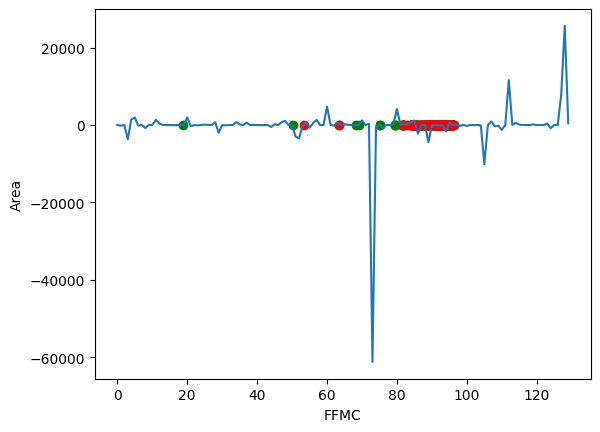

In [215]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

X_poly = PolynomialFeatures(degree=9).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, Y_log)
lr_poly = LinearRegression().fit(X_train, y_train)
y_pred = lr_poly.predict(X_test)
print("Polynomial training set R^2: {:.2f}".format(lr_poly.score(X_train, y_train)))
print("Polynomial test set R^2: {:.2f}".format(lr_poly.score(X_test, y_test)))

# Display them
plt.plot(y_pred)
plt.scatter(X_train[:,1],y_train, color = 'green')
plt.scatter(X_test[:,1],y_test, color = 'red')
plt.xlabel("FFMC")
plt.ylabel("Area")

A little overfit

# Ground vs Weather

There are some features that look like they can be separated into different categories. Do those have any impact?

In [161]:
X_ground = forest_fires.drop(columns=['month','day','X','Y','wind','rain','temp','RH','area'])
X_weather = forest_fires.drop(columns=['month','day','X','Y','FFMC','DMC','DC','ISI','area'])
X_location = forest_fires.drop(columns=['month','day','FFMC','DMC','DC','ISI','wind','rain','temp','RH','area'])

print(X.columns)
print(X_ground.columns)
print(X_weather.columns)
print(X_location.columns)

X_gscaled = scaler.fit_transform(X_ground)
X_wscaled = scaler.fit_transform(X_weather)
X_lscaled = scaler.fit_transform(X_date)

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_gscaled, Y_log
)

groundlr = LinearRegression().fit(X_train, y_train_log)

print("Ground training set R^2: {:.2f}".format(groundlr.score(X_train, y_train_log)))
print("Ground test set R^2: {:.2f}".format(groundlr.score(X_test, y_test_log)))

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_wscaled, Y_log
)

weatherlr = LinearRegression().fit(X_train, y_train_log)

print("Weather training set R^2: {:.2f}".format(weatherlr.score(X_train, y_train_log)))
print("Weather test set R^2: {:.2f}".format(weatherlr.score(X_test, y_test_log)))

X_train, X_test, y_train_log, y_test_log = train_test_split(
    X_lscaled, Y_log
)

locationlr = LinearRegression().fit(X_train, y_train_log)

print("Location training set R^2: {:.2f}".format(datelr.score(X_train, y_train_log)))
print("Location test set R^2: {:.2f}".format(datelr.score(X_test, y_test_log)))

#Somehow make a function that displays each combo of factors against each other

Index(['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain'], dtype='object')
Index(['FFMC', 'DMC', 'DC', 'ISI'], dtype='object')
Index(['temp', 'RH', 'wind', 'rain'], dtype='object')
Index(['X', 'Y'], dtype='object')
Ground training set R^2: 0.02
Ground test set R^2: -0.06
Weather training set R^2: 0.03
Weather test set R^2: -0.07
Location training set R^2: 0.01
Location test set R^2: -0.01


## Analyzing Correlations
After looking at these scores and their lackluster results we decided to check the correltations between the attributes and the target area.

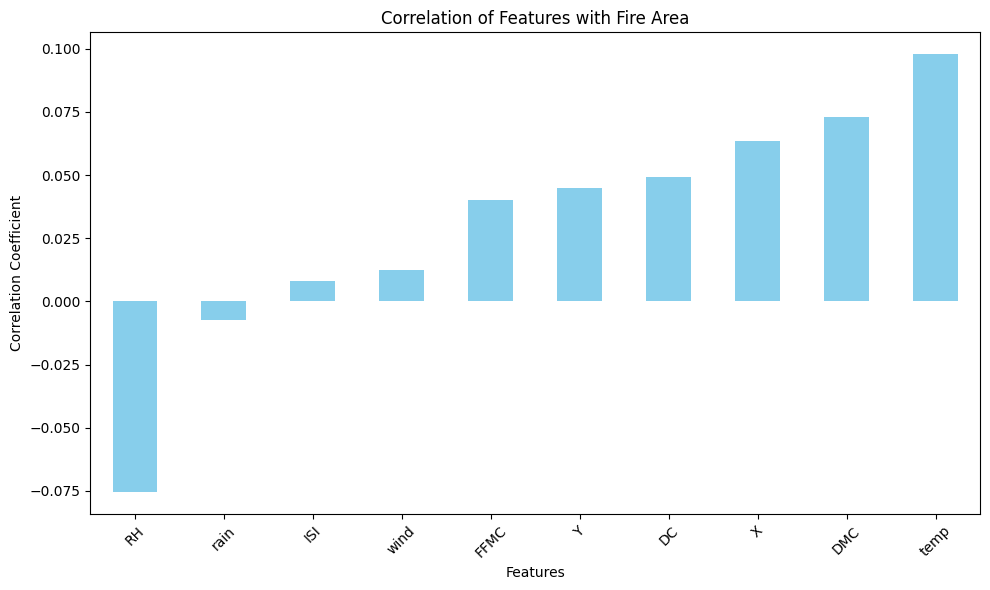

In [60]:
# Calculate correlations
X_num = forest_fires.drop(columns = ['month','day'])
correlation_matrix = X_num.corr()

plt.figure(figsize=(10, 6))
# Create bar plot of correlations with area
area_correlations = correlation_matrix['area'].drop('area')
area_correlations.sort_values().plot(kind='bar', color='skyblue')
plt.title('Correlation of Features with Fire Area')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Switching to Binary Classification

It is clear that regression simply won't work with the given correlations, or at least with the models that we have learned about. Given that a large portion of our target values are 0, it makes a lot of sense to switch this from a regression problem to binary classification where our two classes are area values of 0 and nonzero. This essentially makes it a question of, given certain weather conditions has or hasn't a fire occured?

## Data Transformation
Once again, we need to transform the data but just the Y this time, making our target values binary.

In [61]:
#transform to either 0 or 1
Y_bin = Y.copy()
#Y_bin['area'] = (Y_bin['area'] != 0).astype(int)
threshold = 0
Y_bin[Y_bin <= threshold] = 0
Y_bin[Y_bin > threshold] = 1


# Split into training and test sets for classification
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, Y_bin, test_size=0.2, random_state=42
)

print("Number of fire cases (1):", (Y_bin['area'] == 1).sum())
print("Number of no-fire cases (0):", (Y_bin['area'] == 0).sum())

Number of fire cases (1): 270
Number of no-fire cases (0): 247


Is there any sort of distinction between non fires and fires across attributes?

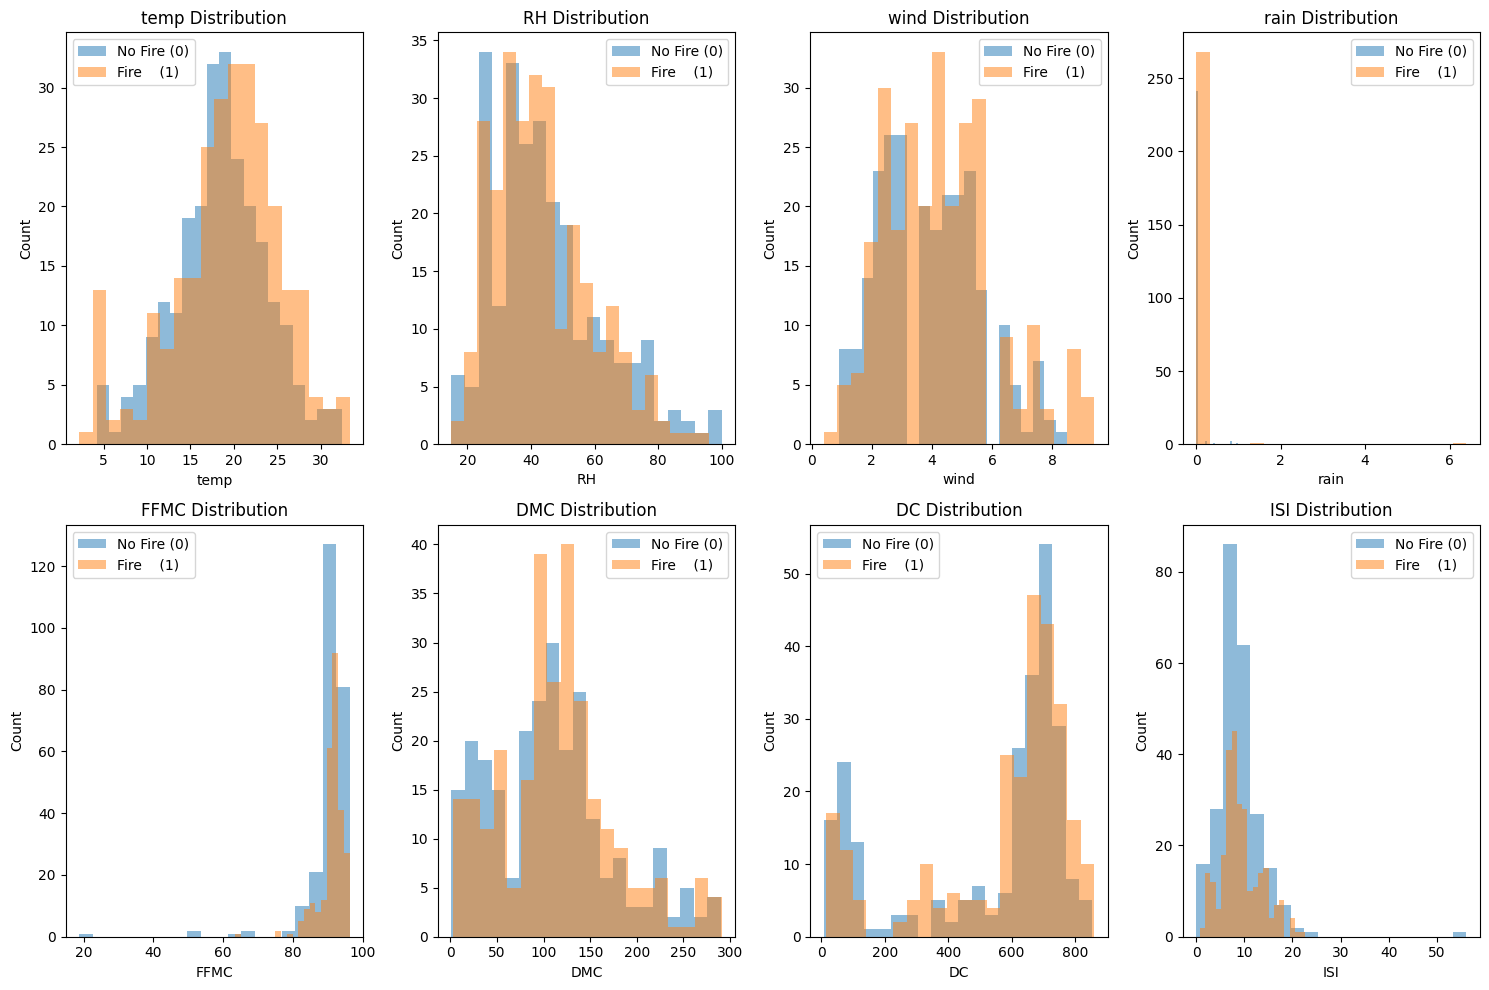

In [62]:
# recombine X and Y_bin so you have a single DataFrame to slice
data_bin = X.copy()
data_bin['area'] = Y_bin['area']

n_rows = 2      # for example
n_cols = 4      # depends on how many features you have
features = ['temp', 'RH', 'wind', 'rain', 'FFMC', 'DMC', 'DC', 'ISI']

#source: https://python-graph-gallery.com/529-multi-group-histogram-pandas
plt.figure(figsize=(15, 5 * n_rows))
for i, feature in enumerate(features):
    plt.subplot(n_rows, n_cols, i + 1)
    
    no_fire = data_bin[data_bin['area'] == 0][feature]
    fire    = data_bin[data_bin['area'] == 1][feature]
    
    plt.hist(no_fire, bins=20, alpha = 0.5, label='No Fire (0)')
    plt.hist(fire,    bins=20, alpha = 0.5, label='Fire    (1)')
    
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.show()

## Classification Models


In [63]:
#knn
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_bin, y_train_bin)
print("KNN - Scores")
print("Training set score: {:.2f}".format(knn.score(X_train_bin, y_train_bin)))
print("Test set score of knn: {:.2f}\n".format(knn.score(X_test_bin, y_test_bin)))

#Logistic Regression
log_reg = LogisticRegression(solver= 'liblinear',  C=100,max_iter= 10000)
log_reg.fit(X_train_bin, y_train_bin) 
y_pred = log_reg.predict(X_test_bin)
print("Logistic Regression - Scores")
print("Training set score: {:.2f}".format(log_reg.score(X_train_bin, y_train_bin)))
print("Test set score: {:.2f}\n".format(log_reg.score(X_test_bin, y_test_bin)))


#SVM
svm = SVC(kernel='rbf', C=1000, tol=0.1 )
svm.fit(X_train_bin, y_train_bin)
y_pred_svm = svm.predict(X_test_bin)
print("SVM - Scores")
print("Training set score: {:.2f}".format(svm.score(X_train_bin, y_train_bin)))
print("Test set score: {:.2f}\n".format(svm.score(X_test_bin, y_test_bin)))

#MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp.fit(X_train_bin, y_train_bin)
y_pred_mlp = mlp.predict(X_test_bin)
print("MLP - Scores")
print("Training set score: {:.2f}".format(mlp.score(X_train_bin, y_train_bin)))
print("Test set score: {:.2f}\n".format(mlp.score(X_test_bin, y_test_bin)))

#PCA + KNN
#standardize first
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bin)
X_test_scaled  = scaler.transform(X_test_bin)

#Fit PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

#train using knn
pca_knn = KNeighborsClassifier(n_neighbors=10)
pca_knn.fit(X_train_pca, y_train_bin)
print("PCA + KNN - Scores")
print("  Train: {:.2f}".format(pca_knn.score(X_train_pca, y_train_bin)))
print("  Test : {:.2f}\n".format(pca_knn.score(X_test_pca,  y_test_bin)))

# reshape
n_features = X_train_scaled.shape[1]
X_train_cnn = X_train_scaled.reshape(-1, n_features, 1)
X_test_cnn  = X_test_scaled.reshape(-1, n_features, 1)

# Build model
tf.random.set_seed(42)
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_features, 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=16, kernel_size=2, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = cnn_model.fit(X_train_cnn, y_train_bin.values, epochs=30, batch_size=16, validation_split=0.1,verbose=1
)

# Evaluate on test
test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test_bin.values)
print(f"\nCNN (1D) - Test accuracy: {test_acc:.2f}")


/penv/lib64/python3.9/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/penv/lib64/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/penv/lib64/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

KNN - Scores
Training set score: 0.66
Test set score of knn: 0.61

Logistic Regression - Scores
Training set score: 0.56
Test set score: 0.55

SVM - Scores
Training set score: 0.61
Test set score: 0.60

MLP - Scores
Training set score: 0.56
Test set score: 0.55

PCA + KNN - Scores
  Train: 0.65
  Test : 0.55

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4247 - loss: 0.6994 - val_accuracy: 0.5238 - val_loss: 0.6893
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5114 - loss: 0.6919 - val_accuracy: 0.5238 - val_loss: 0.6885
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5658 - loss: 0.6889 - val_accuracy: 0.5714 - val_loss: 0.6904
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5904 - loss: 0.6859 - val_accuracy: 0.5952 - val_loss: 0.6918
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6111 - loss: 0.6831 - val_accuracy: 0.5952 - val_loss: 0.6923
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accurac

Classification does not perform well with just an even split, but as we change the threshold value and start grouping the no fire and the small fire records together we steadily get more accurate.

In [65]:
#transform to either 0 or 1
Y_bin = Y.copy()
#Y_bin['area'] = (Y_bin['area'] != 0).astype(int)
threshold = 10
Y_bin[Y_bin <= threshold] = 0
Y_bin[Y_bin > threshold] = 1

# Split into training and test sets for classification
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, Y_bin, test_size=0.2, random_state=42
)

print("Number of fire cases (1):", (Y_bin['area'] == 1).sum())
print("Number of no-fire cases (0):", (Y_bin['area'] == 0).sum(),"\n")

#knn
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_bin, y_train_bin)
print("KNN - Scores")
print("Training set score: {:.2f}".format(knn.score(X_train_bin, y_train_bin)))
print("Test set score of knn: {:.2f}\n".format(knn.score(X_test_bin, y_test_bin)))

#Logistic Regression
log_reg = LogisticRegression(solver= 'liblinear',  C=100,max_iter= 10000)
log_reg.fit(X_train_bin, y_train_bin) 
y_pred = log_reg.predict(X_test_bin)
print("Logistic Regression - Scores")
print("Training set score: {:.2f}".format(log_reg.score(X_train_bin, y_train_bin)))
print("Test set score: {:.2f}\n".format(log_reg.score(X_test_bin, y_test_bin)))

#SVM
svm = SVC(kernel='rbf', C=1000, tol=0.1 )
svm.fit(X_train_bin, y_train_bin)
y_pred_svm = svm.predict(X_test_bin)
print("SVM - Scores")
print("Training set score: {:.2f}".format(svm.score(X_train_bin, y_train_bin)))
print("Test set score: {:.2f}\n".format(svm.score(X_test_bin, y_test_bin)))

#MLP
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp.fit(X_train_bin, y_train_bin)
y_pred_mlp = mlp.predict(X_test_bin)
print("MLP - Scores")
print("Training set score: {:.2f}".format(mlp.score(X_train_bin, y_train_bin)))
print("Test set score: {:.2f}\n".format(mlp.score(X_test_bin, y_test_bin)))

#PCA + KNN
#standardize first
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bin)
X_test_scaled  = scaler.transform(X_test_bin)

#Fit PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

#train using knn
pca_knn = KNeighborsClassifier(n_neighbors=10)
pca_knn.fit(X_train_pca, y_train_bin)
print("PCA + KNN - Scores")
print("  Train: {:.2f}".format(pca_knn.score(X_train_pca, y_train_bin)))
print("  Test : {:.2f}\n".format(pca_knn.score(X_test_pca,  y_test_bin)))




Number of fire cases (1): 95
Number of no-fire cases (0): 422 

KNN - Scores
Training set score: 0.82
Test set score of knn: 0.80

Logistic Regression - Scores
Training set score: 0.82
Test set score: 0.80

SVM - Scores
Training set score: 0.82
Test set score: 0.80



/penv/lib64/python3.9/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/penv/lib64/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/penv/lib64/python3.9/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/penv/lib64/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1105: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

MLP - Scores
Training set score: 0.82
Test set score: 0.80

PCA + KNN - Scores
  Train: 0.82
  Test : 0.80



/penv/lib64/python3.9/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Let's check the predicted values and see if the model is predicting only 0's or only 1's.

In [66]:
# Assume y_test_bin is a pandas Series (or you can wrap your array in one)
results = pd.DataFrame({
    'Actual':    y_test_bin['area'].values, 
    'Predicted': y_pred
}, index=y_test_bin.index)

# Show the first 10 rows side-by-side
print(results.head(10))
# Show count of each combination (Actual vs. Predicted)
print(pd.crosstab(results['Actual'], results['Predicted'],
                  rownames=['Actual'], colnames=['Predicted']))

     Actual  Predicted
304     0.0        0.0
501     0.0        0.0
441     0.0        0.0
153     0.0        0.0
503     0.0        0.0
131     0.0        0.0
204     1.0        0.0
512     0.0        0.0
325     0.0        0.0
247     0.0        0.0
Predicted  0.0
Actual        
0.0         83
1.0         21


## Classification Conclusion

It would appear that clustering the small & non-zero fire instances has a positive impact on our classification model. At first I believed that this was because the model would default to randomly guessing 0 even when the threshold was lower, and because of that, when the nonzero groups gets smaller, the model gets lucky. Instead, it appears that as the threshold gets larger and we start treating small fires similar to no fire instances, models across the board are able to more accurately predict the area. 